<a href="https://colab.research.google.com/github/samarthsoni17/ideal-ML-train/blob/workbench/Tweet_Emotion_Recognition_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [4]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
     |████████████████████████████████| 243 kB 45.5 MB/s 


In [5]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.7.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [6]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [7]:
dataset
# it is divided into 3 "sets", each with a text and label
# numrows = number of train/test/val examples in the sets respectively

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [8]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [66]:
# let's take a look at the set (of training)
def get_twe̵̵et(set):
    tweets = [ x['text'] for x in set]
    labels = [ x['label'] for x̵̵̵ in set]

    return tweets, labels

In [10]:
# get tweets and labels for training set
tweets, labels = get_tweet(train)

In [11]:
# lets take a look at one example
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

In [12]:
# lets take a look at one example
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'sadness')

## Task 4: Tokenizer

1. Tokenizing the tweets

In [13]:
# tensorflow comes with a built in tokenizer
# tokenizatoin means assigning nuerical values to each word so that we can perform ML on the data
# in our case, tf gives each word of the dataset a unique number
# we can set a limit to how much frequently occuring words are tokenized, and which less frequently used words to ignore
# the less commonly used words can be given a common token that represents 'out-of-vocabulary' or an unknown word token

from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
# let's use 10000 ost frequently used words from our corpus
#the oov token is a string which is unlikely to occur in the dataset; it in turn also has a numeric value

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

#create a mapping from words to numeric tokens:
tokenizer.fit_on_texts(tweets)

In [15]:
tokenizer.texts_to_sequences('i didnt feel humiliated')

[[2],
 [],
 [669],
 [2],
 [669],
 [1726],
 [43],
 [],
 [1997],
 [1550],
 [1550],
 [8884],
 [],
 [6051],
 [966],
 [93],
 [2],
 [8884],
 [2],
 [7],
 [43],
 [1550],
 [669]]

In [16]:
tweets[0]

'i didnt feel humiliated'

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

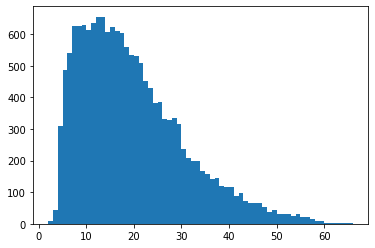

In [17]:
# since our model needs an input of fixed length, we may need to pad/truncate our data
# let's csalculate the lengths of all tweets in the training set

#split seperates the sentences into words
lengths = [len(tweet.split(' ')) for tweet in tweets]

# lets plot a histogram to visualise what is the mean length of our data
plt.hist(lengths, bins = len(set(lengths))) #bins are set to number of unique lengths we have in our dataset

plt.show()
#note that we have no tweets less than 2-3 words or more than 60 words

In [18]:
# let's truncate all tweets over 50 words
maxlen = 50

#let's pad strings lesser than 50 with zeroes
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [19]:
# define a function to get sequences for our different sets
# truncating = post => truncating will happen at the end of the sequence
# padding = post => padding will happen at the end of the sequence

def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets) # this time, we pass all examples together
    padded = pad_sequences(sequences, truncating = 'post', padding = 'post', maxlen = maxlen)
    return padded # all examples of same length

In [20]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [21]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [22]:
classes = set(labels)
print(classes)

{'anger', 'love', 'sadness', 'surprise', 'fear', 'joy'}


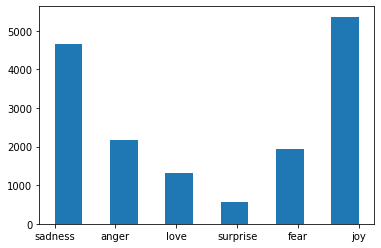

In [32]:
plt.hist(labels, bins = 11)
plt.show()
# we can see our data faces Class Imbalance Problem

In [35]:
 # lets create a dictoinary with classname c as key and some index i as value
class_to_index = dict((c, i) for i, c in enumerate(classes) )

 # lets create another dictoinary with index as keys k and classnames as values v
index_to_class = dict( (v, k) for k, v in class_to_index.items() )

In [36]:
class_to_index

{'anger': 0, 'fear': 4, 'joy': 5, 'love': 1, 'sadness': 2, 'surprise': 3}

In [37]:
index_to_class

{0: 'anger', 1: 'love', 2: 'sadness', 3: 'surprise', 4: 'fear', 5: 'joy'}

In [38]:
# lets use a lambda (anonymous functoin definition that is not bound to an identifier i.e. a functoin name)
names_to_ids = lambda labels: np.array( [class_to_index.get(x) for x in labels] ) 
#we are converting the names of labels/classes in each example to numbers

print(names_to_ids)

<function <lambda> at 0x7f0544123560>


In [41]:
train_labels = names_to_ids( labels )

print( train_labels[0] )
# the first example had label "sadness" and thus we expect a value of '2' to be returned, in light of the value of 'sadness' in 'class_to_index'

2


## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [49]:
# we simply pass a list of layers to tf to create our model

model = tf.keras.Sequential( [
        # In the Embedding layer, Each token is encoded as a 16 dimensional vector
        # the first dimension (10k) typically used for batch size
        # The output of the layer are going to have 50 tokens each with a 16 dimensional embedding i.e dim = (50, 16)
        tf.keras.layers.Embedding( 10000, 16, input_length = maxlen), 

        # now, an LSTM layer:
        # Using LSTM layer inside Bidirectoinal layer means, content can go both L->R and R->L
        # using 20 cells; r_s=True means we will have output at every timestep
        # Unless we return all sequential outputs from the first bidirectional LSTM, this code will not work!
        tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(20, return_sequences=True) ),

        tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(20) ),
        # uptil here was the RNN part

        # now, the dense layer:
        tf.keras.layers.Dense( 6, activation = 'Softmax' ) # output = 6 units for the 6 classes we have
] )

model.compile(

    loss = 'sparse_categorical_crossentropy',
    # we use this because ours is a multiclass classification problem, and
    # our data is not one-hot-encoded

    optimizer = 'adam',
    metrics = ['accuracy']
)

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [56]:
val_tweets, val_labels = get_tweet( val )

val_seq = get_sequences( tokenizer, val_tweets )

val_labels = names_to_ids( val_labels )

In [62]:
print( val_tweets[0], '\n', val_seq[0], '\n', val_labels[0] )

im feeling quite sad and sorry for myself but ill snap out of it soon 
 [ 17   8 157 260   4 343  16  51  19 212   1  50  10  13 533   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 
 2


In [64]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),

    epochs = 20,

    callbacks = [
                 tf.keras.callbacks.EarlyStopping ( monitor = 'val_accuracy', patience = 2 )
    ] # if there is not imporvement in val accuracy for over two epochs, the model stops early
)

Epoch 1/20
500/500 [==============================] - 39s 60ms/step - loss: 1.2666 - accuracy: 0.5074 - val_loss: 0.7828 - val_accuracy: 0.7080
Epoch 2/20
500/500 [==============================] - 28s 56ms/step - loss: 0.5549 - accuracy: 0.7941 - val_loss: 0.5848 - val_accuracy: 0.7935
Epoch 3/20
500/500 [==============================] - 28s 56ms/step - loss: 0.3274 - accuracy: 0.8878 - val_loss: 0.4763 - val_accuracy: 0.8515
Epoch 4/20
500/500 [==============================] - 28s 56ms/step - loss: 0.2306 - accuracy: 0.9262 - val_loss: 0.4633 - val_accuracy: 0.8650
Epoch 5/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1753 - accuracy: 0.9464 - val_loss: 0.4282 - val_accuracy: 0.8730
Epoch 6/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1456 - accuracy: 0.9532 - val_loss: 0.3872 - val_accuracy: 0.8865
Epoch 7/20
500/500 [==============================] - 28s 56ms/step - loss: 0.1402 - accuracy: 0.9573 - val_loss: 0.4219 - val_accuracy:

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

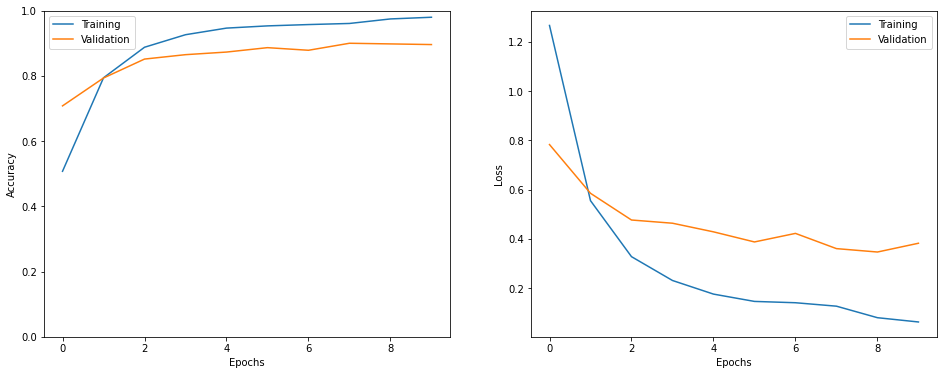

In [65]:
show_history( h )

In [67]:
test_tweets, test_labels = get_tweet( test )

test_seq = get_sequences( tokenizer, test_tweets )

test_labels = names_to_ids( test_labels )

In [68]:
_ = model.evaluate( test_seq, test_labels )

63/63 [==============================] - 1s 21ms/step - loss: 0.3769 - accuracy: 0.8925


In [69]:
i = random.randint( 0, len(test_labels) - 1 ) #taking a random example from the test set
print( 'Sentence: ', test_tweets[i] )
print( 'Emotion: ', index_to_class[test_labels[i]] )

#prediction:
p = model.predict( np.expand_dims( test_seq[i], axis = 0 ) )[0] # taking first element back from prediction
# expand dimensoins is simply to make the test input an appropriate shape with just one example
pred_class = index_to_class[ np.argmax(p).astype('uint8') ] #convert the argmax of prediction to an integer

print( 'Predicted Emotion: ', pred_class )

Sentence:  i feel very saddened that the king whom i once quite respected as far as monarchs go was ineffectual at best
Emotion:  joy
Predicted Emotion:  joy


#### Lets take a look at all prediction against all the ground truths

In [73]:
preds2 = np.argmax( model.predict( test_seq), axis = -1 )
# preds = model.predict_classes( test_seq ) # we do predict_classes instead of predict because in the latter, the predictions will be of a different shape 

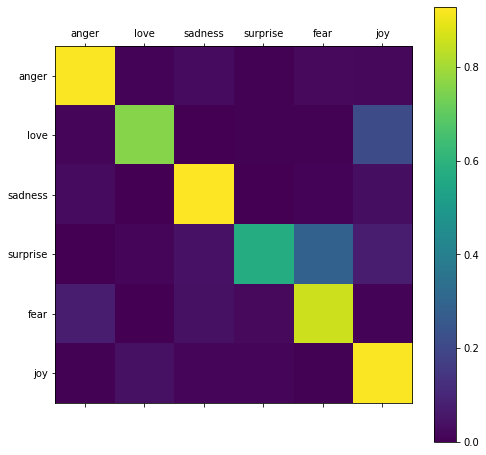

In [75]:
show_confusion_matrix( test_labels, preds2, list(classes) )

# we can see that we have done a pretty decent job
# most predictions are correct except most common misclassifications between
# surprise and fear, &
# joy and love

# this misclassification could be reduced if we had more examples for some of the classes which were underrepresented in our training data set